<a href="https://colab.research.google.com/github/koji1211/node-red-contrib-infomotion/blob/master/covid19_ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize_matplotlib fbprophet pydrive scikit-learn==0.24

     |████████████████████████████████| 4.1MB 8.9MB/s 
     |████████████████████████████████| 22.2MB 66.0MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=5a5ba54d0549155ae66a041add8d36c4de1abff5c87743fc3ed5eea1bd2cfb73
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# 因果インパクト法と時系列予測ライブラリProphetを利用したGoToの影響検証

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import copy
import datetime
import matplotlib.pyplot as plt
import itertools
import japanize_matplotlib

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

In [ ]:
# 補助関数類

def convert_to_ds_y_format(df):
    ''' 
    Prophetモデルの入力形式にデータフレームを変換する。
    入力：
    - dfは１つのカラムからなる日付をindexとして持つSeries
    '''
    return pd.DataFrame({'ds': df.index, 'y':df.values})


def grid_search(df, regressors=[]):
    """
    パラメータのグリッドサーチ
    https://facebook.github.io/prophet/docs/diagnostics.html
    """
    rmses = []  # Store the RMSEs for each params here
    param_grid = {  
        'changepoint_range': [0.8, 0.9, 1.0],
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.08, 0.1, 0.5, 0.8, 1.0],
        'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20],
        "seasonality_mode": ["additive", "multiplicative"]
    }
# Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params)
        for reg in regressors:
            m.add_regressor(reg)
        m.fit(df)  # Fit model with given params
        df_cv = cross_validation(m, initial='240 days',horizon='30 days', period="30 days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    return tuning_results,  all_params[np.argmin(rmses)]

def prophet_plot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6)
):
    """Plot the Prophet forecast.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    Returns
    -------
    A matplotlib figure.
    from https://github.com/facebook/prophet/blob/master/python/fbprophet/plot.py
    https://github.com/facebook/prophet/blob/master/python/fbprophet/plot.py
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2)
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

In [ ]:
# データの読み込み
# covid-19-open-dataのepidemiologyデータの読み込み
epid_df = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv', parse_dates=['date'])

# Googleのデータは海外時間のため、1日ズレており、その補正を行う
epid_df['date'] = epid_df['date'] + datetime.timedelta(days=1)

# 東京都と全国の検査関連データを取得
japan_df = epid_df[epid_df.key=='JP'].sort_values(by=['date']).set_index('date')
 
# 全国の検査陽性者数と検査数を取得
japan_new_confirmed = japan_df.new_confirmed.copy()

In [ ]:
# パラメータ群
#search_result, best_param = grid_search(convert_to_ds_y_format(japan_new_confirmed))
#best_param
CHANGEPOINT_PRIOR_SCALE = 0.5
SEASONALITY_PRIOR_SCALE = 0.5
CHANGEPOINT_RANGE = 0.9
SEASONALITY_MODE= "multiplicative"

## Prophetモデルの学習/評価と学習/予測コード

In [ ]:
def train_evaluate_prophet(series, train_period, eval_period, \
                            hide_plots=False, title='', y_label='検査陽性者数',
                           changepoint_prior_scale=CHANGEPOINT_PRIOR_SCALE, changepoint_range=CHANGEPOINT_RANGE,
                           seasonality_prior_scale=SEASONALITY_PRIOR_SCALE,
                           seasonality_mode=SEASONALITY_MODE):
    """
    prophetの時系列予測性能を評価する
    """
    # 学習データと予測データに分け、Prophetの入力フォーマットに変換
    train_df = convert_to_ds_y_format(series.loc[train_period[0]:train_period[1]])
    eval_df = convert_to_ds_y_format(series.loc[eval_period[0]:eval_period[1]])
    
    m = Prophet(
                seasonality_mode=seasonality_mode, 
                seasonality_prior_scale=seasonality_prior_scale, 
                changepoint_range=changepoint_range, changepoint_prior_scale=changepoint_prior_scale)
    m.fit(train_df)
    future = m.make_future_dataframe(periods=len(eval_df))
    forecast = m.predict(future)

    if not hide_plots:
        # 予測と正解をプロット
        fig = prophet_plot(m, forecast)
        ax = fig.gca()
        ax.set_title(title, fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)
        ax.set_xlabel('日付', fontsize=15)
        plt.scatter(eval_df.ds, eval_df.y, marker=".", c="#b24000")
        plt.show()
    
    print('')
    print('MAPE: {}'.format(mape(eval_df.y,\
                                 forecast[(forecast['ds']>=eval_period[0])&(forecast['ds']<=eval_period[1])].yhat)))
    print('MSE: {}'.format(mse(eval_df.y,\
                                 forecast[(forecast['ds']>=eval_period[0])&(forecast['ds']<=eval_period[1])].yhat)))
    print('')
    
    if not hide_plots:
        # Prophetのコンポーネントをプロットする
        print('Prophetモデルの予測寄与成分の内訳')
        m.plot_components(forecast)
        plt.show()
    
    return m, forecast

In [ ]:
def train_predict_prophet(series, train_period, pred_period,
                          hide_plots=False, title='', y_label='検査陽性者数',
                          changepoint_prior_scale=CHANGEPOINT_PRIOR_SCALE, changepoint_range=CHANGEPOINT_RANGE,
                          seasonality_prior_scale=SEASONALITY_PRIOR_SCALE,
                          seasonality_mode=SEASONALITY_MODE):
    """
    予測結果のみを表示
    """
    # 学習データと予測データに分け、Prophetの入力フォーマットに変換
    train_df = convert_to_ds_y_format(series.loc[train_period[0]:train_period[1]])
    
    # 学習と予測
    m = Prophet(
                        seasonality_mode=seasonality_mode,
                        seasonality_prior_scale=seasonality_prior_scale,
                       changepoint_range=changepoint_range, changepoint_prior_scale=changepoint_prior_scale)
    m.fit(train_df)
    future = m.make_future_dataframe(periods=(pred_period[1]-pred_period[0]).days+1)
    forecast = m.predict(future)
        
    if not hide_plots:
        # 予測と正解をプロット
        fig = prophet_plot(m, forecast)
        ax = fig.gca()
        ax.set_title(title, fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)
        ax.set_xlabel('日付', fontsize=15)
        ax.legend()
        plt.show()

        print('')

        # Prophetのコンポーネントをプロットする
        print('Prophetモデルの予測寄与成分の内訳')
        m.plot_components(forecast)
        plt.show()
    
    return m, forecast

In [ ]:
def plot_one_prophet_and_one_real(m, fcst, pred_period, series, uncertainty=True, xlabel='日付',
                                  ylabel1='検査陽性者数', ylabel2='検査陽性者数に対する影響', ylabel3='検査陽性者数に対する累積影響',
                                  title='GoToトラベル実施による全国検査陽性者数への影響', figsize=(15,9)):
    """
    介入なしを仮定したProphetの予測と介入ありの実測値の差（影響）をプロットする関数
    """
    title_fontsize = 16
    fontsize = 12
    pred_days = (pred_period[1]-pred_period[0]).days+1
    fig = plt.figure(facecolor='w', figsize=figsize)
    
    ax = fig.add_subplot(311)  
    fcst_t = fcst['ds'].dt.to_pydatetime()
    true_line, = ax.plot(fcst_t, series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]], 'k')
    true_line.set_label('実測値')
    counterfactual_pred_line, = ax.plot(fcst_t, fcst['yhat'], ls='--', c='#0072B2')
    counterfactual_pred_line.set_label('GoToが未実施だった場合の予測値')
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2)
        
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel1, fontsize=fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.legend(loc='upper left', fontsize=fontsize)
    ax.axvline(x=pred_period[0], color='black', ls='--')
    
    ax2 = fig.add_subplot(312)
    counterfactual_pred_effect_line, = ax2.plot(fcst_t, series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]].values-fcst['yhat'].values, ls='--', c='#0072B2')
    counterfactual_pred_effect_line.set_label('GoTo実施の影響の推定値')
    
    if uncertainty:
        ax2.fill_between(fcst_t, series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]].values-fcst['yhat_lower'].values, series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]].values-fcst['yhat_upper'].values,
                        color='#0072B2', alpha=0.2)
    
    ax2.set_xlabel(xlabel, fontsize=fontsize)
    ax2.set_ylabel(ylabel2, fontsize=fontsize)
    ax2.axhline(y=1, color='black', ls='--')
    ax2.axvline(x=pred_period[0], color='black', ls='--')
    ax2.legend(loc='upper left', fontsize=fontsize)

    ax3 = fig.add_subplot(313)
    diff = series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]][-pred_days:].values-fcst['yhat'][-pred_days:].values
    lower_diff = fcst['yhat'][-pred_days:].values-fcst['yhat_lower'][-pred_days:].values
    upper_diff =  fcst['yhat_upper'][-pred_days:].values- fcst['yhat'][-pred_days:].values
    counterfactual_pred_effect_accum_line, = ax3.plot(fcst_t[-pred_days:], (series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]][-pred_days:].values-fcst['yhat'][-pred_days:].values).cumsum(), ls='--', c='#0072B2')
    counterfactual_pred_effect_accum_line.set_label('GoTo実施の影響の推定値：累積')
    if uncertainty:
        ax3.fill_between(fcst_t[-pred_days:], (series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]][-pred_days:].values-fcst['yhat_lower'][-pred_days:].values).cumsum(), (series.loc[fcst['ds'].values[0]: fcst['ds'].values[-1]][-pred_days:].values-fcst['yhat_upper'][-pred_days:].values).cumsum(),
                        color='#0072B2', alpha=0.2)
    ax3.set_xlabel(xlabel, fontsize=fontsize)
    ax3.set_ylabel(ylabel3, fontsize=fontsize)
    ax3.axhline(y=1, color='black', ls='--')
    ax3.axvline(x=pred_period[0], color='black', ls='--')
    ax3.legend(loc='upper left', fontsize=fontsize)
    fig.tight_layout()
    return fig, diff, lower_diff, upper_diff

In [ ]:
def plot_prediction_and_sub_ci_prophets(m1, fcst1, m2, diff, lower_diff, upper_diff, pred_period, uncertainty=True, 
                                           xlabel='日付', ylabel1='検査陽性者数', ylabel2='検査陽性者数への影響', ylabel3='検査陽性者数への累積影響',
                                           title='', figsize=(15,9), actday=pd.Timestamp('2020-12-28')):
    """
    介入ありと介入なしを仮定した２つのProphet予測の差（影響）をプロットする
    """
    title_fontsize = 16
    fontsize = 12
    pred_days = (pred_period[1]-pred_period[0]).days + 1
    ci_days = (pred_period[1] - actday).days + 1
    fig = plt.figure(facecolor='w', figsize=figsize)
    
    ax = fig.add_subplot(311)  
    fcst1_t = fcst1['ds'].dt.to_pydatetime()
    true_line, = ax.plot(m1.history['ds'].dt.to_pydatetime(), m1.history['y'], 'k')
    true_line.set_label('実測値')
    continuation_pred_line, = ax.plot(fcst1_t, fcst１['yhat'], ls='--', c='#0072B2')
    continuation_pred_line.set_label('継続予測値')
    stop_pred =  fcst１['yhat'][-ci_days:] - diff[:ci_days]
    stop_pred_line = ax.plot(fcst1_t[-ci_days:], stop_pred, ls='--', c='#b24000')[0]
    stop_pred_line.set_label('停止予測値')
    if uncertainty:
        # 継続予測値のエラーバー
        ax.fill_between(fcst1_t, fcst1['yhat_lower'], fcst1['yhat_upper'],
                        color='#0072B2', alpha=0.2)        
        
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel1, fontsize=fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.legend(loc='upper left', fontsize=fontsize)
    ax.axvline(x=actday, color='black', ls='--')
   
    ax2 = fig.add_subplot(312)
    stop_pred_effect_line = ax2.plot(fcst1_t[-ci_days:], -diff[:ci_days], ls="--", c='#b24000')[0]
    stop_pred_effect_line.set_label("goto継続予測値とgoto停止予測値の差")
    continuation_pred_diff_line, = ax2.plot(m1.history['ds'].dt.to_pydatetime(), m1.history['y']-fcst1['yhat'][:-pred_days], ls='--', c='#0072B2')
    continuation_pred_diff_line.set_label('実測値と12/25までの予測値の差')
    
    if uncertainty:
        ax2.fill_between(fcst1_t[:-pred_days], m1.history['y']-fcst1['yhat_lower'][:-pred_days], m1.history['y']-fcst1['yhat_upper'][:-pred_days],
                         color='#0072B2', alpha=0.2)
        ax2.fill_between(fcst1_t[-ci_days:],  -diff[:ci_days]+lower_diff[:ci_days],
                         -diff[:ci_days]-upper_diff[:ci_days],
                         color='#b24000', alpha=0.2)
    ax2.set_xlabel(xlabel, fontsize=fontsize)
    ax2.set_ylabel(ylabel2, fontsize=fontsize)
    ax2.axhline(y=1, color='black', ls='--')
    ax2.axvline(x=actday, color='black', ls='--')
    ax2.legend(loc='upper left', fontsize=fontsize)

    ax3 = fig.add_subplot(313)
    stop_pred_effect_accum_line = ax3.plot(fcst1_t[-ci_days:], -diff[:ci_days].cumsum(), ls="--", c='#b24000')[0]
    stop_pred_effect_accum_line.set_label("goto継続予測値とgoto停止予測値の差の累積値")
    if uncertainty:
        ax3.fill_between(fcst1_t[-ci_days:], 
                         -diff[:ci_days].cumsum()+lower_diff[:ci_days].cumsum(), 
                         -diff[:ci_days].cumsum()-upper_diff[:ci_days].cumsum(),
                             color='#b24000', alpha=0.2)
    ax3.set_xlabel(xlabel, fontsize=fontsize)
    ax3.set_ylabel(ylabel3, fontsize=fontsize)
    ax3.axhline(y=1, color='black', ls='--')
    ax3.axvline(x=actday, color='black', ls='--')
    ax3.legend(loc='lower left', fontsize=fontsize)
    ax3.xaxis.set_ticks(pd.date_range(actday, pred_period[1]))
    fig.tight_layout()
    return fig

## 学習と評価を行う場合（評価期間の正解データが必要）
### １．学習期間と予測期間の定義

In [ ]:
train_period = [pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-14')]
eval_period = [pd.Timestamp('2020-12-15'), pd.Timestamp('2020-12-25')]

### ２．Prophetモデルの予測と評価

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


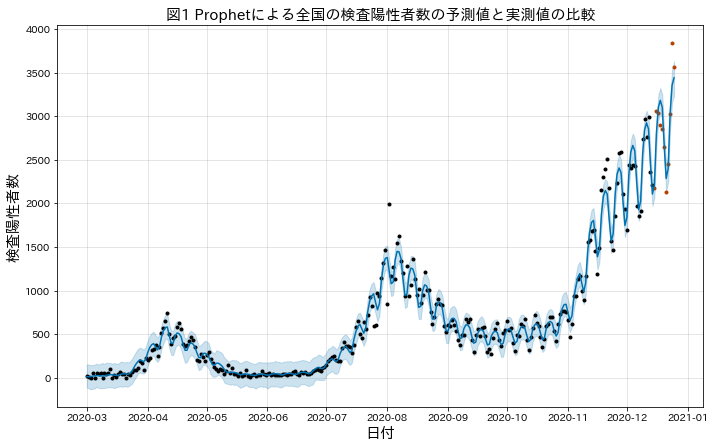


MAPE: 0.05265721529792645
MSE: 45765.67220731775

Prophetモデルの予測寄与成分の内訳


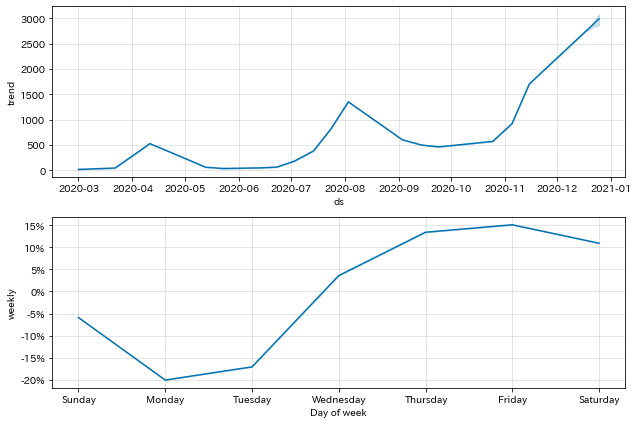

In [ ]:
m_stop_goto, forecast_stop_goto = train_evaluate_prophet(japan_new_confirmed, train_period, eval_period,
                                                             title="図1 Prophetによる全国の検査陽性者数の予測値と実測値の比較")

## 学習と予測を行う場合（予測期間の正解データは不要）

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


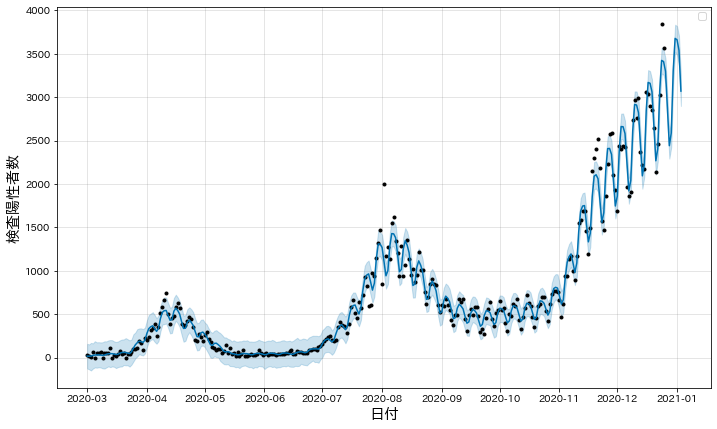


Prophetモデルの予測寄与成分の内訳


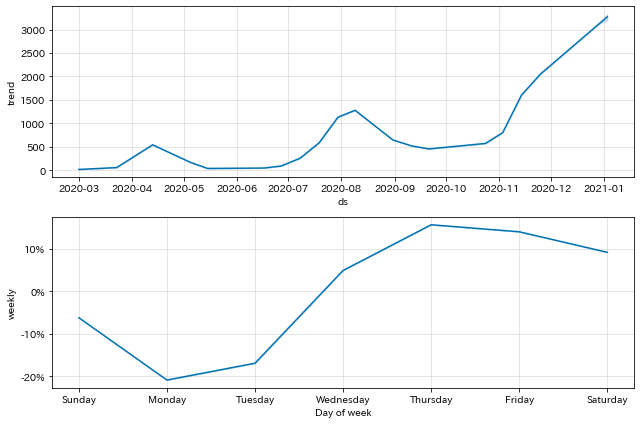

In [ ]:
train_period = [pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-25')]
pred_period = [pd.Timestamp('2020-12-26'), pd.Timestamp('2021-01-03')]
m_stop_goto, forecast_stop_goto = train_predict_prophet(japan_new_confirmed, train_period, pred_period)

## GoTo実施vsGoTo未実施の影響測定

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


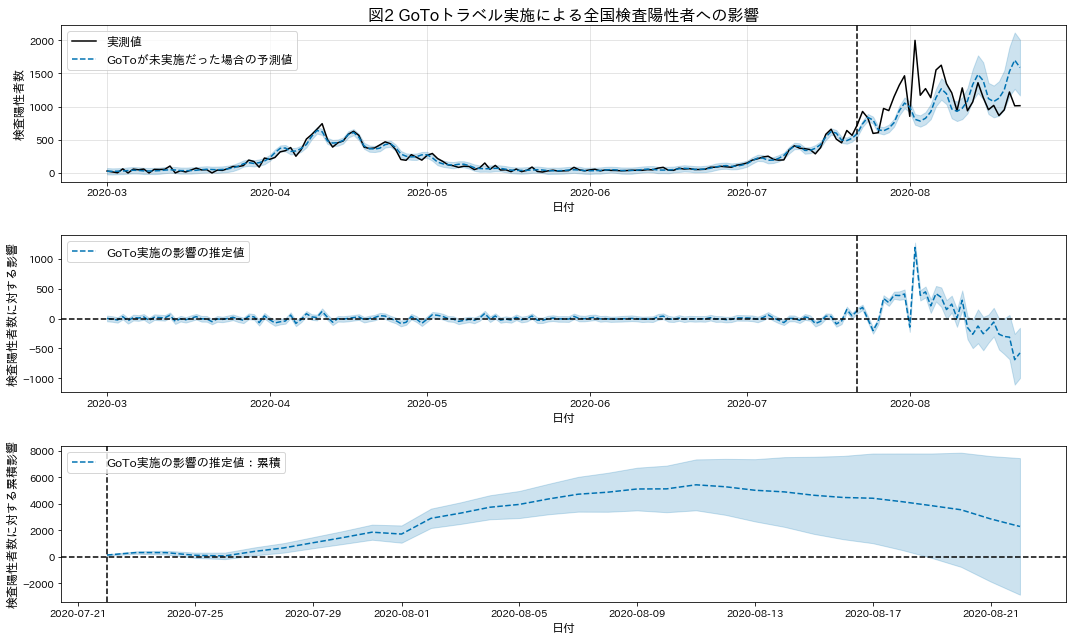

In [ ]:
train_period = [pd.Timestamp('2020-03-01'), pd.Timestamp('2020-07-21')]
pred_period = [pd.Timestamp('2020-07-22'), pd.Timestamp('2020-08-22')]
m_722nogoto, forecast_notstart_goto = train_predict_prophet(japan_new_confirmed, train_period, pred_period,
                                                            hide_plots=True,)
_, goto_722diff, goto_722lower_diff, goto_722upper_diff = plot_one_prophet_and_one_real(
    m_722nogoto, forecast_notstart_goto, pred_period, japan_new_confirmed,
    title="図2 GoToトラベル実施による全国検査陽性者への影響");

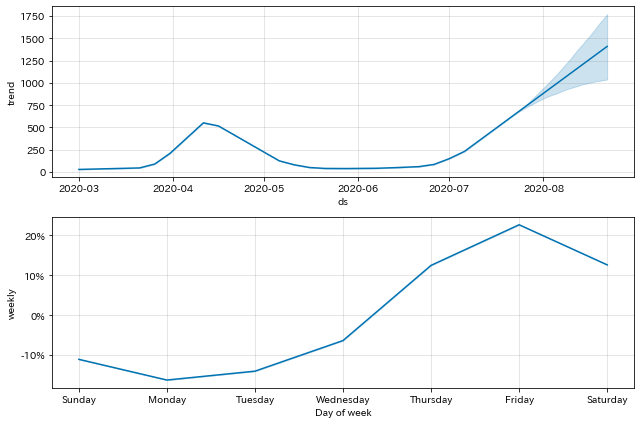

In [ ]:
m_722nogoto.plot_components(forecast_notstart_goto);

## Gotoトラベル東京+gotoイートの影響

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


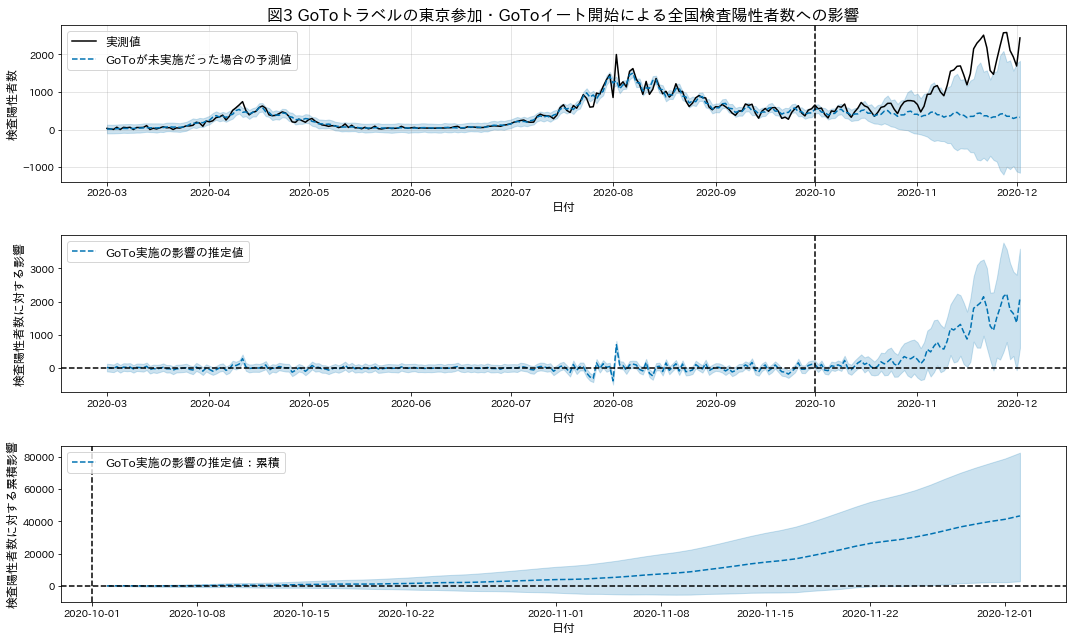

In [ ]:
train_period = [pd.Timestamp('2020-03-01'), pd.Timestamp('2020-10-01')]
pred_period = [pd.Timestamp('2020-10-01'), pd.Timestamp('2020-12-01')]
m_tokyo_goto, forecast_tokyo_goto = train_predict_prophet(japan_new_confirmed, train_period, pred_period, hide_plots=True)
_, gte_diff, gte_lower, gteupper = plot_one_prophet_and_one_real(m_tokyo_goto, 
                                                                 forecast_tokyo_goto, pred_period, japan_new_confirmed, 
                                                                 title='図3 GoToトラベルの東京参加・GoToイート開始による全国検査陽性者数への影響',);

## GoTo停止実施vsGoTo継続の影響予測

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


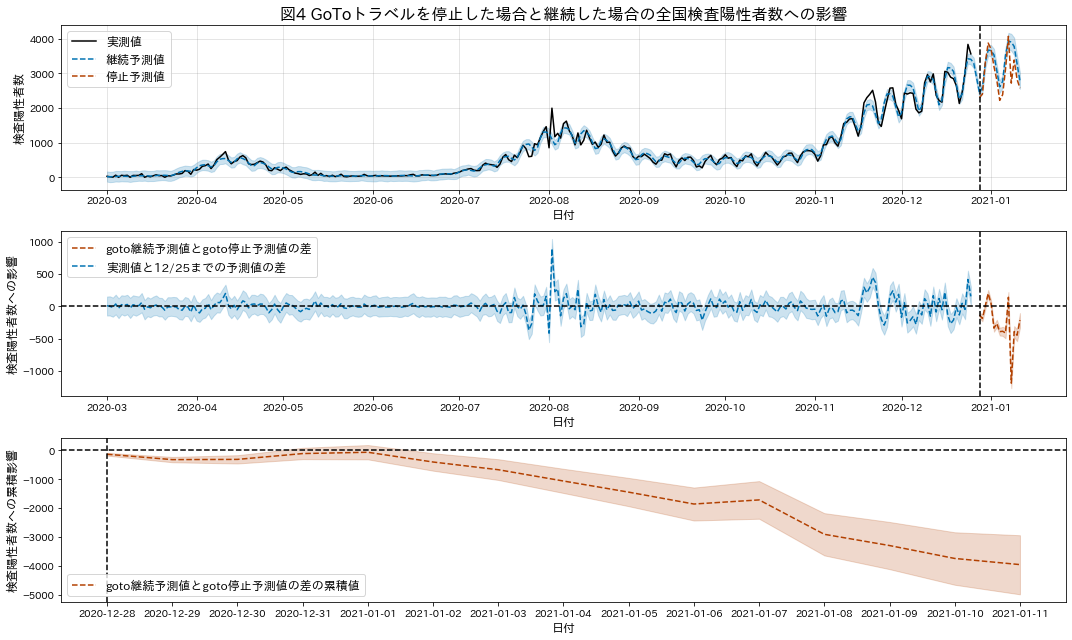

In [ ]:
train_period = [pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-25')]
pred_period = [pd.Timestamp('2020-12-26'), pd.Timestamp('2021-01-11')]
#現在のトレンドを引き継いだGoTo継続を想定したモデルの学習と予測
m_nonstop_goto, forecast_nonstop_goto = train_predict_prophet(japan_new_confirmed, train_period, pred_period, hide_plots=True)
plot_prediction_and_sub_ci_prophets(
    m_nonstop_goto, forecast_nonstop_goto, m_722nogoto, goto_722diff, goto_722lower_diff, goto_722upper_diff,
    pred_period, actday=pd.Timestamp('2020-12-28'),
    title='図4 GoToトラベルを停止した場合と継続した場合の全国検査陽性者数への影響');